In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.datasets import fetch_olivetti_faces
from sklearn.decomposition import PCA
from sklearn.neural_network import BernoulliRBM
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, classification_report, roc_curve,
    precision_recall_curve, auc, f1_score
)
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Binarizer

In [13]:
def load_data():
    faces = fetch_olivetti_faces()
    X = faces.data
    y = (faces.target == 0).astype(int)
    return train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


def scale_and_binarize(X_train, X_test):
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    binarizer = Binarizer(threshold=0.5)
    return binarizer.transform(X_train_scaled), binarizer.transform(X_test_scaled)


In [ ]:
def tune_pca(X_train, y_train):
    pipe = Pipeline([
        ('pca', PCA()),
        ('clf', LogisticRegression(max_iter=1000))
    ])
    param_grid = {
        'pca__n_components': [0.90, 0.95, 0.98, 100, 150]
    }
    grid = GridSearchCV(pipe, param_grid, scoring='f1', cv=3)
    grid.fit(X_train, y_train)
    print(f"Best PCA params: {grid.best_params_}")
    return grid.best_estimator_.named_steps['pca']


def tune_rbm(X_train, y_train):
    pipe = Pipeline([
        ('rbm', BernoulliRBM(random_state=42)),
        ('clf', LogisticRegression(max_iter=1000))
    ])
    param_grid = {
        'rbm__n_components': [100, 200, 300],
        'rbm__learning_rate': [0.005, 0.01, 0.02],
        'rbm__n_iter': [10, 20, 50]
    }
    grid = GridSearchCV(pipe, param_grid, scoring='f1', cv=3, verbose=1)
    grid.fit(X_train, y_train)
    print(f"Best RBM params: {grid.best_params_}")
    return grid.best_estimator_.named_steps['rbm']


def tune_svm():
    return GridSearchCV(
        SVC(probability=True),
        param_grid={
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']
        },
        scoring='f1',
        cv=StratifiedKFold(n_splits=3)
    )


In [15]:
def train_and_eval_models(X_train, X_test, y_train, y_test, label):
    models = {
        "SVM": tune_svm()
    }
    results = {}
    for name, model in models.items():
        start = time.time()
        model.fit(X_train, y_train)
        elapsed = time.time() - start

        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        print(f"\n📊 [{label} - {name}] Accuracy: {acc:.4f} | F1: {f1:.4f} | Time: {elapsed:.2f}s")
        print(classification_report(y_test, y_pred))

        fpr, tpr, _ = roc_curve(y_test, y_prob)
        prec, rec, _ = precision_recall_curve(y_test, y_prob)

        results[name] = {
            "model": model,
            "acc": acc,
            "f1": f1,
            "time": elapsed,
            "prob": y_prob,
            "fpr": fpr,
            "tpr": tpr,
            "prec": prec,
            "rec": rec
        }
    return results


In [16]:
def plot_curves(results, title_prefix):
    plt.figure(figsize=(12, 5))
    for idx, metric in enumerate(["roc", "pr"]):
        plt.subplot(1, 2, idx + 1)
        for method, data in results.items():
            if metric == "roc":
                plt.plot(data["fpr"], data["tpr"], label=f"{method} (AUC: {auc(data['fpr'], data['tpr']):.2f})")
                plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"{title_prefix} - ROC Curve")
            else:
                plt.plot(data["rec"], data["prec"], label=f"{method}")
                plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"{title_prefix} - PR Curve")
        plt.legend()
        plt.grid(True)
    plt.tight_layout()
    plt.show()

In [17]:
def violin_plot(results, y_test, title_prefix):
    for method, data in results.items():
        df = pd.DataFrame({"Prob": data["prob"], "Label": y_test})
        plt.figure(figsize=(6, 4))
        sns.violinplot(x="Label", y="Prob", data=df)
        plt.title(f"{title_prefix} - {method} Violin")
        plt.grid(True)
        plt.show()

In [18]:
def plot_training_time(*args):
    methods, times = [], []
    for label, result in args:
        for model, val in result.items():
            methods.append(f"{label}-{model}")
            times.append(val["time"])
    plt.figure(figsize=(10, 5))
    sns.barplot(x=methods, y=times)
    plt.title("Training Time Comparison")
    plt.xticks(rotation=45)
    plt.ylabel("Seconds")
    plt.grid(True)
    plt.show()

In [19]:
def reconstruct_rbm(rbm, original):
    hidden = rbm.transform(original)
    recon = np.dot(hidden, rbm.components_) + rbm.intercept_visible_
    return 1 / (1 + np.exp(-recon))


In [20]:
def visualize_reconstruction(original, pca, rbm):
    recon_pca = pca.inverse_transform(pca.transform(original)).reshape(64, 64)
    recon_rbm = reconstruct_rbm(rbm, original).reshape(64, 64)

    plt.figure(figsize=(10, 3))
    plt.subplot(1, 3, 1)
    plt.imshow(original.reshape(64, 64), cmap="gray")
    plt.title("Original"); plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(recon_pca, cmap="gray")
    plt.title("PCA Reconstructed"); plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(recon_rbm, cmap="gray")
    plt.title("RBM Reconstructed"); plt.axis("off")

    plt.tight_layout()
    plt.show()

In [21]:
X_train, X_test, y_train, y_test = load_data()
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [22]:
pca = tune_pca(X_train_std, y_train)
X_train_pca = pca.transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

✅ Best PCA params: {'pca__n_components': 0.9}


In [23]:
X_train_bin, X_test_bin = scale_and_binarize(X_train, X_test)
rbm = tune_rbm(X_train_bin, y_train)
X_train_rbm = rbm.transform(X_train_bin)
X_test_rbm = rbm.transform(X_test_bin)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
✅ Best RBM params: {'rbm__learning_rate': 0.005, 'rbm__n_components': 100, 'rbm__n_iter': 10}


In [24]:
results_raw = train_and_eval_models(X_train_std, X_test_std, y_train, y_test, "Raw")
results_pca = train_and_eval_models(X_train_pca, X_test_pca, y_train, y_test, "PCA")
results_rbm = train_and_eval_models(X_train_rbm, X_test_rbm, y_train, y_test, "RBM")


📊 [Raw - SVM] Accuracy: 1.0000 | F1: 1.0000 | Time: 3.41s
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        78
           1       1.00      1.00      1.00         2

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80


📊 [PCA - SVM] Accuracy: 0.9875 | F1: 0.6667 | Time: 0.24s
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        78
           1       1.00      0.50      0.67         2

    accuracy                           0.99        80
   macro avg       0.99      0.75      0.83        80
weighted avg       0.99      0.99      0.99        80


📊 [RBM - SVM] Accuracy: 0.9750 | F1: 0.0000 | Time: 0.13s
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        78
           1       0.00      0.00      0.00         2

    a

C:\Users\kanih\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\kanih\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\kanih\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

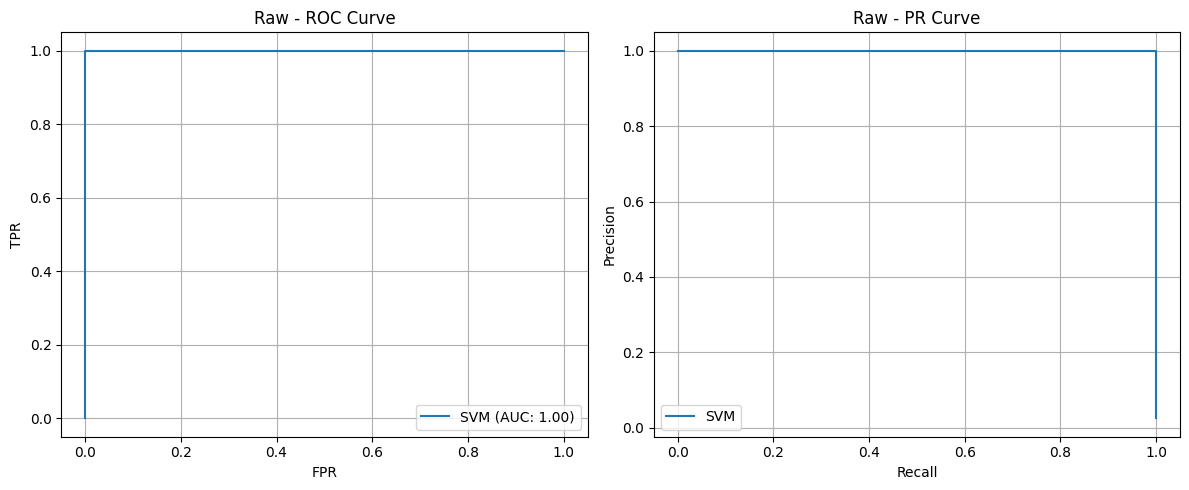

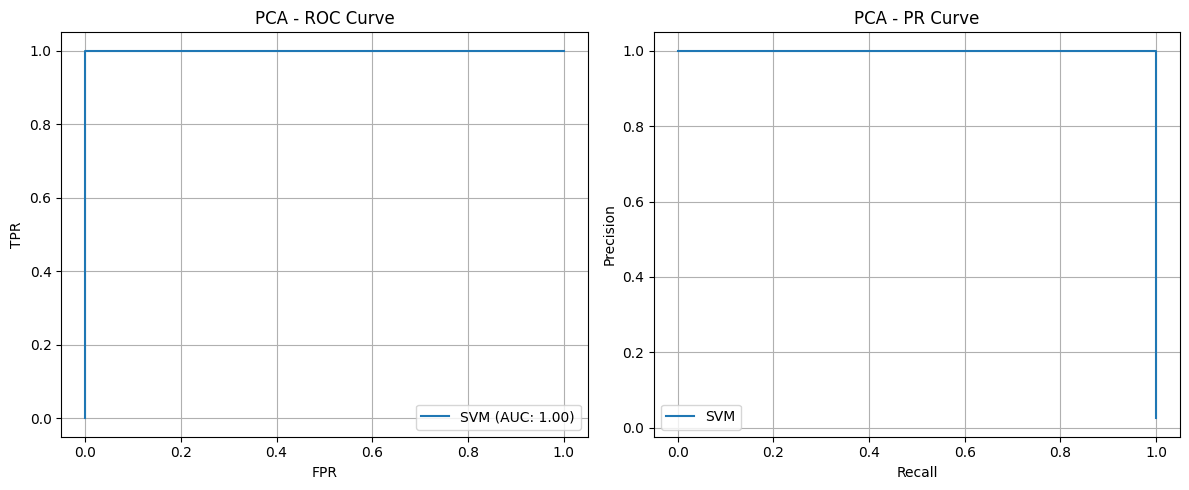

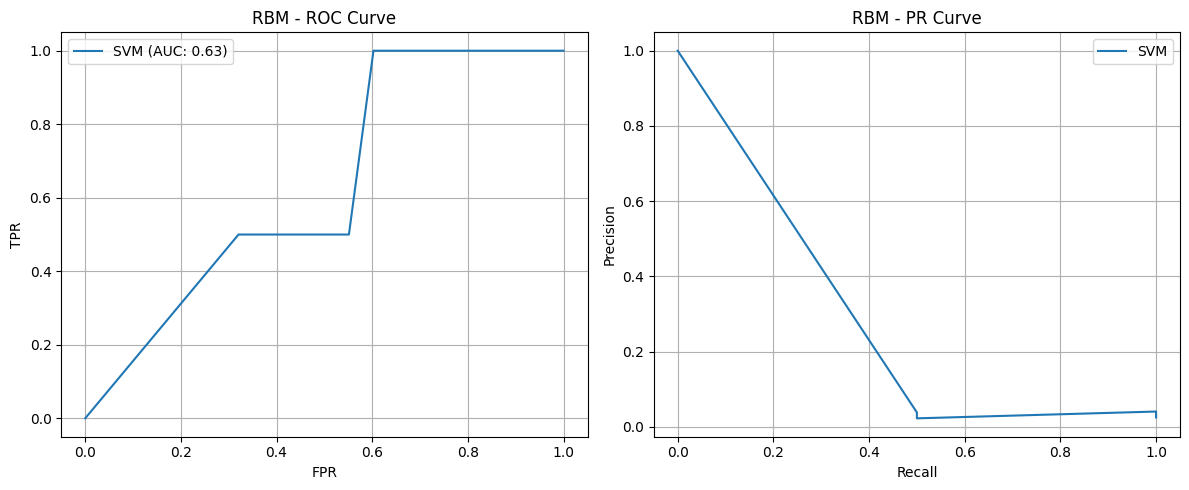

In [25]:
plot_curves(results_raw, "Raw")
plot_curves(results_pca, "PCA")
plot_curves(results_rbm, "RBM")

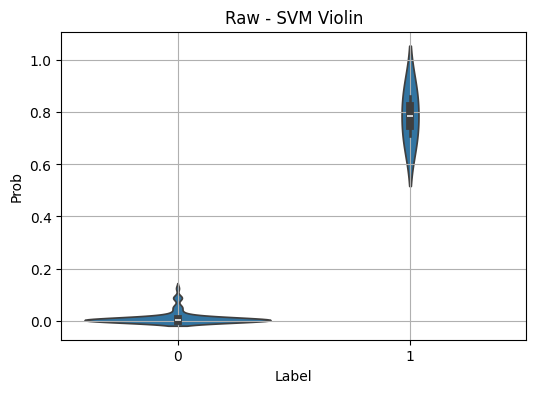

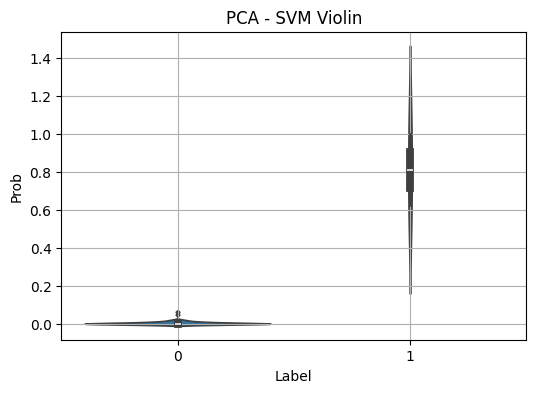

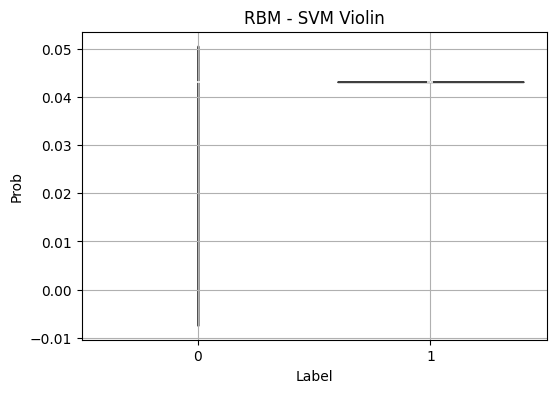

In [26]:
violin_plot(results_raw, y_test, "Raw")
violin_plot(results_pca, y_test, "PCA")
violin_plot(results_rbm, y_test, "RBM")

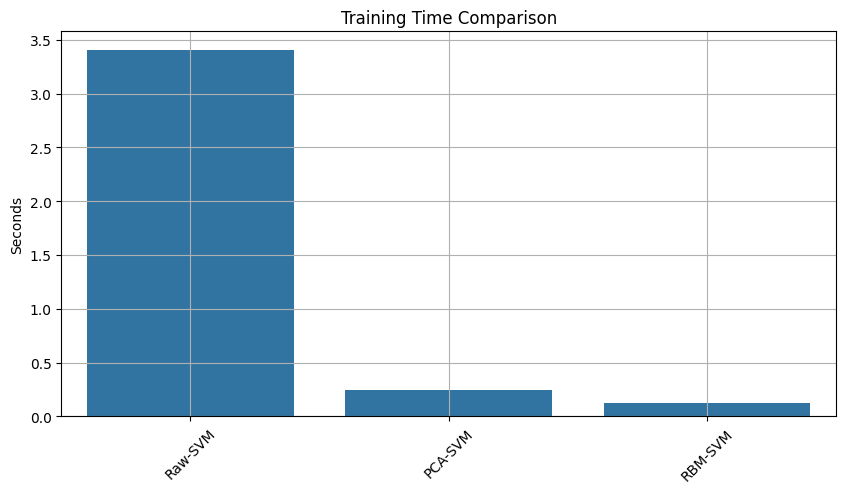

In [27]:
plot_training_time(("Raw", results_raw), ("PCA", results_pca), ("RBM", results_rbm))

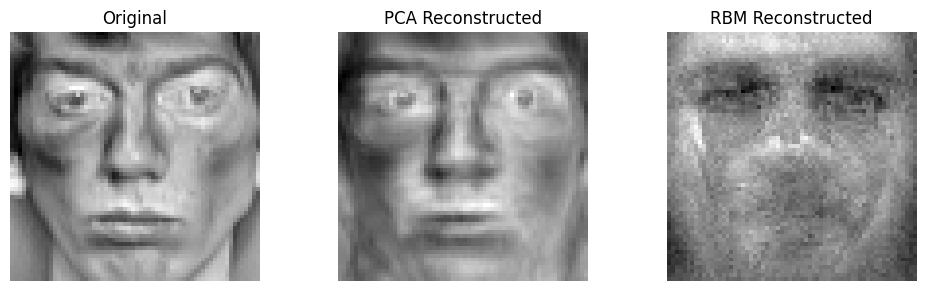

In [28]:
visualize_reconstruction(X_test_std[0].reshape(1, -1), pca, rbm)